Using backend: pytorch
D:\software\Anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
D:\software\Anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


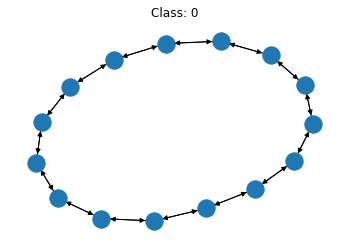

In [1]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

dataset = MiniGCDataset(80, 10, 20)
# 上面参数的意思是生成80个图，每个图的最小节点数>=10, 最大节点数<=20
graph, label = dataset[0]  # 拿出第一个数据（图，标签）进行展示
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)   # 将图转为networkx形式
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [2]:
graph

Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={})

In [3]:
import dgl
import torch

def collate(samples):
    # 输入参数samples是一个列表
    # 列表里的每个元素是图和标签对，如[(graph1, label1), (graph2, label2), ...]
    graphs, labels = map(list, zip(*samples))
    return dgl.batch(graphs), torch.tensor(labels, dtype=torch.long)

testset = MiniGCDataset(80, 10, 20) 
graph, label = collate(testset)
print(graph)
print(label)
print(label.shape)

Graph(num_nodes=1083, num_edges=6527,
      ndata_schemes={}
      edata_schemes={})
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])
torch.Size([80])


In [4]:
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)  # 定义第一层图卷积
        self.conv2 = GraphConv(hidden_dim, hidden_dim)  # 定义第二层图卷积
        self.classify = nn.Linear(hidden_dim, n_classes)   # 定义分类器

    def forward(self, g):
        """g表示批处理后的大图，N表示大图的所有节点数量，n表示图的数量 
        """
        # 我们用节点的度作为初始节点特征。对于无向图，入度 = 出度
        h = g.in_degrees().view(-1, 1).float() # [N, 1]
        # 执行图卷积和激活函数
        h = F.relu(self.conv1(g, h))  # [N, hidden_dim]
        h = F.relu(self.conv2(g, h))  # [N, hidden_dim]
        g.ndata['h'] = h    # 将特征赋予到图的节点
        # 通过平均池化每个节点的表示得到图表示
        hg = dgl.mean_nodes(g, 'h')   # [n, hidden_dim]
        return self.classify(hg)  # [n, n_classes]

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader

# 创造训练集和测试集
trainset = MiniGCDataset(2000, 10, 20) 
testset = MiniGCDataset(1000, 10, 20) 

In [6]:
%%time

# 用pytorch的DataLoader和之前定义的collect函数
data_loader = DataLoader(trainset, batch_size=512, shuffle=True,
                         collate_fn=collate)

# 构造模型 
model = Classifier(1, 256, trainset.num_classes)
# 定义分类交叉熵损失
loss_func = nn.CrossEntropyLoss()
# 定义Adam优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 模型训练
model.train()
epoch_losses = []
for epoch in range(200): 
    epoch_loss = 0
    for iter, (batchg, label) in enumerate(data_loader):
        prediction = model(batchg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0074
Epoch 1, loss 1.9802
Epoch 2, loss 1.9713
Epoch 3, loss 1.9617
Epoch 4, loss 1.9588
Epoch 5, loss 1.9518
Epoch 6, loss 1.9466
Epoch 7, loss 1.9418
Epoch 8, loss 1.9357
Epoch 9, loss 1.9288
Epoch 10, loss 1.9204
Epoch 11, loss 1.9101
Epoch 12, loss 1.8995
Epoch 13, loss 1.8852
Epoch 14, loss 1.8688
Epoch 15, loss 1.8500
Epoch 16, loss 1.8263
Epoch 17, loss 1.7991
Epoch 18, loss 1.7704
Epoch 19, loss 1.7389
Epoch 20, loss 1.7052
Epoch 21, loss 1.6695
Epoch 22, loss 1.6329
Epoch 23, loss 1.5938
Epoch 24, loss 1.5548
Epoch 25, loss 1.5154
Epoch 26, loss 1.4745
Epoch 27, loss 1.4356
Epoch 28, loss 1.3963
Epoch 29, loss 1.3560
Epoch 30, loss 1.3179
Epoch 31, loss 1.2792
Epoch 32, loss 1.2437
Epoch 33, loss 1.2080
Epoch 34, loss 1.1738
Epoch 35, loss 1.1439
Epoch 36, loss 1.1144
Epoch 37, loss 1.0887
Epoch 38, loss 1.0627
Epoch 39, loss 1.0399
Epoch 40, loss 1.0196
Epoch 41, loss 0.9993
Epoch 42, loss 0.9827
Epoch 43, loss 0.9675
Epoch 44, loss 0.9545
Epoch 45, loss 0.939

In [7]:
# CPU下测试
from sklearn.metrics import accuracy_score

test_loader = DataLoader(testset, batch_size=64, shuffle=False,
                         collate_fn=collate)
model.eval()
test_pred, test_label = [], []
with torch.no_grad():
    for it, (batchg, label) in enumerate(data_loader):
        pred = torch.softmax(model(batchg), 1)
        pred = torch.max(pred, 1)[1].view(-1)
        test_pred += pred.detach().cpu().numpy().tolist()
        test_label += label.cpu().numpy().tolist()
print("accuracy: ", accuracy_score(test_label, test_pred))

accuracy:  0.8125


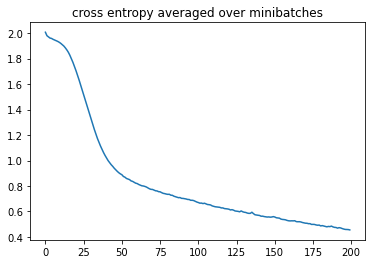

In [8]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()